UDA

Dataset and DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import requests
from torchvision.datasets import ImageFolder
from torchvision import models
from PIL import Image
from shutil import copyfile
import os

In [ ]:
os.chdir('/content/drive/MyDrive/MLDL_project')
from datasets.cityscapes import CityscapesDataset
from datasets.gta5 import GTA5

In [ ]:
import torchvision.transforms as transforms
transform_train_gta = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.5),
    transforms.Resize((720, 1280), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

lbl_transform_train_gta = transforms.Compose([
    transforms.Resize((720,1280), interpolation=Image.Resampling.NEAREST)
])

transform_trian_city = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.5),
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

lbl_transform_trian_city = transforms.Compose([
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

lbl_transform_val = transforms.Compose([
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
])

In [ ]:
train_dataset_source = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[transform_train_gta,lbl_transform_train_gta])
train_dataset_target = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', transform=[transform_trian_city,lbl_transform_trian_city], split='train')
val_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', transform=[transform_val,lbl_transform_val], split='val')

In [ ]:
# Create a DataLoader
from torch.utils.data import DataLoader
dataloader_train_source = DataLoader(train_dataset_source, batch_size=8, shuffle=True, num_workers=8)
dataloader_train_target = DataLoader(train_dataset_target, batch_size=8, shuffle=True, num_workers=8)
dataloader_val = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8)

In [ ]:
num_train_samples_source = len(train_dataset_source)
num_train_samples_target = len(train_dataset_target)
num_val_samples = len(val_dataset)

print(f'Number of source training samples: {num_train_samples_source}')
print(f'Number of target training samples: {num_train_samples_target}')
print(f'Number of validation samples: {num_val_samples}')

Number of source training samples: 2500
Number of target training samples: 1572
Number of validation samples: 500


Build model

In [ ]:
# Load pre-trained model
from models.bisenet.build_bisenet import BiSeNet

In [ ]:
# Load discriminator model
from models.discriminator.discriminator import FCDiscriminator

Trainning process

In [ ]:
import torch.nn.functional as F
from utils import total_hist
from utils import per_class_iou

def train(epoch, model, model_D, dataloader_train_source, dataloader_train_target, criterion, criterion_D, optimizer, optimizer_D, lambda_adv_target):
  model.train()
  model_D.train()
  loss_seg_value = 0.0
  loss_adv_target_value = 0.0
  loss_D_value = 0.0
  hist = 0
  for i, (data_source, data_target) in enumerate(zip(dataloader_train_source, dataloader_train_target)):
    inputs_s, lables_s = data_source[0].cuda(), data_source[1].cuda()
    inputs_t, _ = data_target[0].cuda(), data_target[1].cuda()
    optimizer.zero_grad()
    optimizer_D.zero_grad()

    # train G

    # don't accumulate grads in D
    for param in model_D.parameters():
        param.requires_grad = False

    # train with source
    pre_s,_,_ = model(inputs_s)
    loss_seg = criterion(pre_s, lables_s)
    loss_seg.backward()
    loss_seg_value += loss_seg.item()

    # train with target
    pre_t,_,_ = model(inputs_t)
    D_out = model_D(F.softmax(pre_t))
    loss_adv_target = criterion_D(D_out, torch.full_like(D_out, source_label, dtype=torch.float).cuda())
    loss_adv = lambda_adv_target * loss_adv_target
    loss_adv.backward()
    loss_adv_target_value += loss_adv_target.item()

    # train D

    # bring back requires_grad
    for param in model_D.parameters():
        param.requires_grad = True

    # train with source
    pre_s = pre_s.detach()
    D_out = model_D(F.softmax(pre_s))
    loss_D = criterion_D(D_out, torch.full_like(D_out, source_label, dtype=torch.float).cuda())
    loss_D.backward()
    loss_D_value += loss_D.item()

    # train with target
    pre_t = pre_t.detach()
    D_out = model_D(F.softmax(pre_t))
    loss_D = criterion_D(D_out, torch.full_like(D_out, target_label, dtype=torch.float).cuda())
    loss_D.backward()
    loss_D_value += loss_D.item()

    optimizer.step()
    optimizer_D.step()

    predicted = torch.argmax(pre_s, dim=1)
    hist += total_hist(predicted, lables_s, 19)

  miou_per_class = per_class_iou(hist)
  miou = np.mean(miou_per_class)

  # pay attention, this is different with AdaptSegNet
  loss_seg_value = loss_seg_value / len(dataloader_train_target)
  loss_adv_target_value = loss_adv_target_value / len(dataloader_train_target)
  loss_D_value = loss_D_value / (2 * len(dataloader_train_target))
  print(f"Epoch{epoch+1}, Loss_seg: {loss_seg_value}, Loss_adv: {loss_adv_target_value}, Loss_D: {loss_D_value}, mIOU: {miou}")

  return loss_seg_value, loss_adv_target_value, loss_D_value, miou, miou_per_class

Validation part

In [ ]:
def validation(model, dataloader_val, criterion):

  model.eval()
  val_loss = 0.0
  hist = 0

  with torch.no_grad():
    for i, batch in enumerate(dataloader_val, 0):
      inputs, labels = batch[0].cuda(), batch[1].cuda()

      out = model(inputs)
      loss = criterion(out, labels)
      val_loss += loss.item()
      out = torch.argmax(out, dim=1)
      hist += total_hist(out, labels, 19)

  miou_per_class = per_class_iou(hist)
  miou = np.mean(miou_per_class)
  val_loss = val_loss / len(dataloader_val)
  print(f"Val_Loss_seg: {val_loss}, Val_mIOU: {miou}")
  return val_loss, miou, miou_per_class

With augmentation

In [ ]:
from utils import poly_lr_scheduler
from timeit import default_timer as timer

model = BiSeNet(num_classes = 19, context_path='resnet18').cuda()
# checkpoint = torch.load('/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/biseNet_UDA_epoch50.pth')
# model.load_state_dict(checkpoint)

model_D = FCDiscriminator(num_classes=19).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(model.parameters(), lr=2.5e-2, momentum=0.9, weight_decay=1e-4)

criterion_D = nn.BCEWithLogitsLoss()
optimizer_D = optim.Adam(model_D.parameters(), lr=1e-4, betas=(0.9, 0.99))

# labels for adversarial training
source_label = 0
target_label = 1
# hyper parameter
lambda_adv_target = 0.001
# lambda_adv_target = 0.1

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

epochs = 50
models = []
miou_train_list = []
miou_val_list = []
miou_per_class_train_list = []
miou_per_class_val_list = []

for epoch in range(epochs):
  # after 30 epochs, lambda_adv_target jumped every 5 epochs
  if epoch > 30 and epoch % 5 == 1:
    lambda_adv_target = 0.001 + 0.001 * ((epoch - epochs)**2 / 400)
  else:
    lambda_adv_target = 0.001
  cur_lr = poly_lr_scheduler(optimizer = optimizer, init_lr = 2.5e-2, iter = epoch, lr_decay_iter=1, max_iter=epochs, power=0.9)
  cur_lr_D = poly_lr_scheduler(optimizer = optimizer_D, init_lr = 1e-4, iter = epoch, lr_decay_iter=1, max_iter=epochs, power=0.9)

  print(f"Current learning rate for segmentation model: {cur_lr}, Current learning rate for discriminator: {cur_lr_D}")
  print(f"Current lambda_adv_target: {lambda_adv_target}")
  loss_seg_value, loss_adv_target_value, loss_D_value, miou_train, miou_per_class_train = train(epoch, model, model_D, dataloader_train_source, dataloader_train_target, criterion, criterion_D, optimizer, optimizer_D, lambda_adv_target)
  # every 5 epochs print the miou and loss of validation set
  if epoch % 5 == 0:
    val_loss, miou_val, miou_per_class_val = validation(model, dataloader_val, criterion)
    miou_train_list.append(miou_train)
    miou_val_list.append(miou_val)
    miou_per_class_train_list.append(miou_per_class_train)
    miou_per_class_val_list.append(miou_per_class_val)
    models.append(model.state_dict())
  print("\n")

# Validation after the final epoch
val_loss, val_miou, val_miou_per_class = validation(model, dataloader_val, criterion)
miou_train_list.append(miou_train)
miou_val_list.append(miou_val)
miou_per_class_train_list.append(miou_per_class_train)
miou_per_class_val_list.append(miou_per_class_val)
models.append(model.state_dict())

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 213MB/s]


Current learning rate for segmentation model: 0.025, Current learning rate for discriminator: 0.0001
Current lambda_adv_target: 0.001
Epoch1, Loss_seg: 0.5614388538193582, Loss_adv: 0.9917521101569161, Loss_D: 0.624624585439711, mIOU: 0.25078125594171025
Val_Loss_seg: 0.8358994798054771, Val_mIOU: 0.20328148167112586


Current learning rate for segmentation model: 0.024549546664914382, Current learning rate for discriminator: 9.819818665965754e-05
Current lambda_adv_target: 0.001
Epoch2, Loss_seg: 0.3400439256944027, Loss_adv: 1.225799242857144, Loss_D: 0.5729335895952234, mIOU: 0.35148158572674365


Current learning rate for segmentation model: 0.024098173031463777, Current learning rate for discriminator: 9.63926921258551e-05
Current lambda_adv_target: 0.001
Epoch3, Loss_seg: 0.289098213923159, Loss_adv: 1.2850173070346038, Loss_D: 0.5588889503993358, mIOU: 0.4129445235836315


Current learning rate for segmentation model: 0.023645857984465803, Current learning rate for discriminator

In [ ]:
print(miou_per_class_train_list[-1])

[0.98751021 0.86086236 0.89983053 0.80982625 0.64943227 0.51799984
 0.48605705 0.63829871 0.82278082 0.80814367 0.95517969 0.51287426
 0.57120168 0.90806128 0.90254736 0.94487758 0.91814667 0.66960498
 0.44614325]


In [ ]:
print(miou_per_class_val_list[-1])

[0.82036992 0.25697133 0.75635741 0.2089475  0.09861922 0.21431413
 0.12256041 0.08140053 0.73410302 0.15500003 0.77301967 0.33937389
 0.05235532 0.64513365 0.18748943 0.11236876 0.         0.02703679
 0.00438144]


In [ ]:
print(miou_per_class_train_list[np.argmax(np.array(miou_val_list))])

[0.98098901 0.80460129 0.86822384 0.72125603 0.54359473 0.43503925
 0.32584705 0.48362122 0.79216093 0.7520405  0.94855    0.41177011
 0.44365193 0.86868643 0.84759122 0.89819377 0.88336162 0.57770402
 0.        ]


In [ ]:
print(miou_per_class_val_list[np.argmax(np.array(miou_val_list))])

[0.85656469 0.2707159  0.75802138 0.22622543 0.12407797 0.19197726
 0.12686002 0.08749387 0.76006398 0.21169262 0.76394476 0.34619815
 0.08675764 0.75053915 0.21278094 0.13577883 0.00300681 0.03139791
 0.        ]


In [ ]:
# save best model
import os
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'biseNet_UDA_LAM_epoch{epochs}.pth'

# delete old model files
if os.path.exists(PATH):
    os.remove(PATH)

model = BiSeNet(num_classes = 19, context_path='resnet18').cuda()
model.load_state_dict(models[np.argmax(np.array(miou_val_list))])
torch.save(model.state_dict(), PATH)

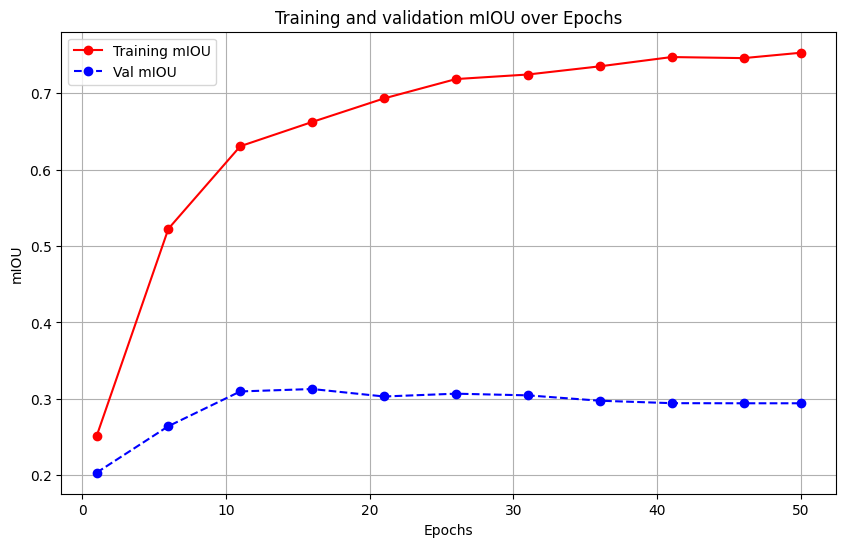

In [ ]:
# visualization
import matplotlib.pyplot as plt

epochs_list = list(np.arange(1, 50+1, 5)) + [50]
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list, marker='o', linestyle='-', color='r', label='Training mIOU')
plt.plot(epochs_list, miou_val_list, marker='o', linestyle='--', color='b', label='Val mIOU')

plt.title('Training and validation mIOU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('mIOU')

plt.legend()
plt.grid(True)
plt.show()